<a href="https://colab.research.google.com/github/xavierjacomep/marketing-basado-en-datos/blob/main/lead-scoring/Marketing_basado_en_datos_Caso_Lead_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conversión de clientes de stuffmart.com
## Caso práctico sobre Clasificación de Leads
---

**Asignatura:** Marketing basado en datos

**Autor:** Xavier Jácome Piñeiros, MSc.

---

## Contexto

La **Clasificación de Leads** es una técnica clave en el marketing digital y las ventas modernas, que permite identificar automáticamente cuáles clientes potenciales tienen mayor probabilidad de convertirse en clientes reales. Esta capacidad predictiva es fundamental para optimizar recursos, priorizar esfuerzos comerciales y diseñar estrategias más efectivas.

En lugar de distribuir recursos uniformemente entre todos los leads, las empresas pueden enfocar sus acciones en aquellos que presentan mayor probabilidad de conversión, incrementando así el retorno de inversión (ROI) y mejorando las tasas de cierre de ventas.


---

## Planteamiento del Problema

**Stuffmart.com** es una empresa emergente de e-commerce que comercializa productos electrónicos, hogar y estilo de vida a través de canales 100% digitales. Con presencia en mercados como Pakistán, India y Bangladesh, su equipo de marketing enfrenta el desafío de mejorar la conversión de leads generados a través de campañas digitales y redes sociales.

Actualmente, su tasa de conversión promedio es inferior al 5%, lo que representa un bajo retorno frente a su inversión publicitaria. La compañía cuenta con un CRM que registra interacciones, fuentes de tráfico, comportamiento en el sitio web, edad, ubicación y otros atributos de los leads.

El equipo ha decidido usar ciencia de datos para implementar un modelo predictivo que identifique a los leads con mayor probabilidad de convertirse en clientes, con el fin de enfocar los esfuerzos comerciales de forma más eficiente.

Tu rol es el de Científico de Datos. La alta dirección te ha encomendado desarrollar una solución de analítica avanzada que permita mejorar la tasa de conversión y optimizar los costos de adquisición de clientes.

El objetivo principal es **construir un modelo de clasificación supervisado** que permita predecir si un lead se convertirá o no en cliente, a partir de un conjunto de variables relacionadas con su comportamiento, perfil demográfico, canal de adquisición, interacción digital y estado actual.

Esto permitirá:
- Priorizar leads con mayor probabilidad de conversión.
- Reducir el costo por adquisición de cliente.
- Personalizar estrategias de seguimiento y comunicación según el perfil del lead.
- Mejorar la eficiencia y efectividad del equipo comercial.

---

## Contenido del Dataset

El conjunto de datos incluye información detallada sobre leads, su comportamiento e interacción con el sitio web, y el resultado final en términos de conversión. Las variables están agrupadas de la siguiente manera:

### 👤 Perfil del Lead
- `LeadID`: Identificador único del lead.
- `Age`: Edad del lead (en años).
- `Gender`: Género del lead.
- `Location`: Ciudad principal desde donde se origina el lead.

### 🚪 Origen y Canal de Captación
- `LeadSource`: Canal por el que se adquirió el lead (e.g., Social Media, Email, Referral).
- `ReferralSource`: Fuente de referencia específica (e.g., Facebook, Google, Twitter).

### 💻 Comportamiento en el Sitio Web
- `TimeSpent`: Tiempo total en minutos que el lead ha pasado en el sitio web.
- `PagesViewed`: Cantidad de páginas web visitadas.
- `FormSubmissions`: Número de formularios completados.
- `Downloads`: Número de descargas realizadas (e.g., brochures, e-books).
- `CTR_ProductPage`: Click-through rate en páginas de productos o servicios.

### 📬 Comunicación y Seguimiento
- `EmailSent`: Número de correos enviados al lead.
- `FollowUpEmails`: Correos de seguimiento enviados.
- `ResponseTime`: Tiempo de respuesta (en horas).
- `LeadStatus`: Estado actual del lead (e.g., Cold, Warm, Hot).

### 📱 Tecnología y Redes Sociales
- `DeviceType`: Tipo de dispositivo usado para acceder al sitio (e.g., Mobile, Desktop).
- `SocialMediaEngagement`: Nivel de interacción en redes sociales (e.g., likes, comentarios, shares).

### 💳 Historial de Pago
- `PaymentHistory`: Estado del historial de pago del lead (e.g., Good, No Payment).

---

## Variable Objetivo

`Conversion`: Variable binaria que indica si el lead se convirtió en cliente (`1`) o no (`0`).
Esta variable será utilizada como variable objetivo para entrenar y evaluar modelos de clasificación supervisados.

---



### 1. Carga y comprensión del dataset
- Importación de librerías necesarias.
- Definición de funciones para pruebas de hipótesis y validación de modelos
- Carga del dataset original en formato `.csv`.
- Exploración inicial de los datos para conocer su estructura y contenido.
---

In [1]:
# ===========================================
# LIBRERÍAS Y CONFIGURACIÓN
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

!pip install feature_engine
from feature_engine.creation import MathFeatures
from feature_engine.discretisation import EqualFrequencyDiscretiser
from scipy.stats import chi2_contingency, kruskal

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

#### Definición de funciones reutilizables

In [2]:
# ===========================================
# FUNCIONES REUTILIZABLES PARA CLASE
# ===========================================

def pruebas_hipotesis_features(df, target, cat_vars, num_vars, alpha=0.05):
    print("Chi-cuadrado para variables categóricas:")
    for col in cat_vars:
        if df[col].isnull().sum() == 0:
            tabla = pd.crosstab(df[col], df[target])
            chi2, p, _, _ = chi2_contingency(tabla)
            print(f"{col}: p = {p:.4e} {'-> Asociación significativa' if p < alpha else ''}")

    print("\nKruskal-Wallis para variables numéricas:")
    for col in num_vars:
        if df[col].isnull().sum() == 0:
            grupos = [df[df[target] == v][col] for v in sorted(df[target].unique())]
            _, p = kruskal(*grupos)
            print(f"{col}: p = {p:.4e} {'-> Diferencias significativas' if p < alpha else ''}")

def comparar_modelos(X_train, y_train, X_test, y_test):
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
    }

    resultados = {}
    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)
        acc = accuracy_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        resultados[nombre] = {'accuracy': acc, 'f1': f1}
        print(f"{nombre}: Accuracy={acc:.4f}, F1={f1:.4f}")

    resultados_df = pd.DataFrame(resultados).T.reset_index().rename(columns={'index': 'Modelo'})
    sns.barplot(data=resultados_df.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
    plt.title('Comparación de Modelos')
    plt.ylabel('Puntaje')
    plt.grid(True)
    plt.show()

#### Carga y preparación del dataset

##### Carga manual desde Google Colab

In [3]:
#from google.colab import files
#uploaded = files.upload()

In [4]:
#df = pd.read_csv('customer_conversion_traing_dataset .csv')
# df.drop(columns=['LeadStatus'], errors='ignore', inplace=True)
#df.head()

##### Carga desde repositorio Github

In [5]:
# ===========================================
# CARGA Y PREPARACIÓN DEL DATASET
# ===========================================
df = pd.read_csv('https://raw.githubusercontent.com/xavierjacomep/marketing-basado-en-datos/refs/heads/main/lead-scoring/customer_conversion_traing_dataset%20.csv')
df.drop(columns=['LeadStatus'], errors='ignore', inplace=True)
df.head()

,LeadID,Age,Gender,Location,LeadSource,TimeSpent (minutes),PagesViewed,EmailSent,DeviceType,ReferralSource,FormSubmissions,Downloads,CTR_ProductPage,ResponseTime (hours),FollowUpEmails,SocialMediaEngagement,PaymentHistory,Conversion (Target)
0,1,60,Female,Faisalabad,Referral,30,13,1,Desktop,Google,4,0,0.3,7,10,195,No Payment,0
1,2,27,Female,Islamabad,Referral,28,4,7,Desktop,Direct,2,2,0.3,13,3,103,No Payment,0
2,3,21,Female,Rawalpindi,Referral,45,10,9,Tablet,Direct,4,2,0.6,10,8,33,No Payment,0
3,4,37,Female,Faisalabad,Email,45,15,5,Desktop,ReferralSite,1,3,0.3,11,1,189,Good,0
4,5,35,Male,Karachi,Referral,31,11,2,Tablet,Google,4,3,0.5,9,2,83,No Payment,0


In [6]:
target = 'Conversion (Target)'
id_col = 'LeadID'

In [7]:
df.isna().sum()

,0
LeadID,0
Age,0
Gender,0
Location,0
LeadSource,0
TimeSpent (minutes),0
PagesViewed,0
EmailSent,0
DeviceType,0
ReferralSource,0


Como se puede observar, no existen valores nulos. Este dataset ya tuvo un preprocesamiento previo.

In [8]:
df.head()

,LeadID,Age,Gender,Location,LeadSource,TimeSpent (minutes),PagesViewed,EmailSent,DeviceType,ReferralSource,FormSubmissions,Downloads,CTR_ProductPage,ResponseTime (hours),FollowUpEmails,SocialMediaEngagement,PaymentHistory,Conversion (Target)
0,1,60,Female,Faisalabad,Referral,30,13,1,Desktop,Google,4,0,0.3,7,10,195,No Payment,0
1,2,27,Female,Islamabad,Referral,28,4,7,Desktop,Direct,2,2,0.3,13,3,103,No Payment,0
2,3,21,Female,Rawalpindi,Referral,45,10,9,Tablet,Direct,4,2,0.6,10,8,33,No Payment,0
3,4,37,Female,Faisalabad,Email,45,15,5,Desktop,ReferralSite,1,3,0.3,11,1,189,Good,0
4,5,35,Male,Karachi,Referral,31,11,2,Tablet,Google,4,3,0.5,9,2,83,No Payment,0


### 2. Ingeniería de características
Se generaron nuevas variables para enriquecer el análisis y mejorar la capacidad predictiva del modelo. Estas variables derivadas se basan en relaciones entre atributos clave del comportamiento digital y la interacción con la empresa:


- `Emails_per_minute`: Tasa de correos enviados por minuto que el lead ha estado en el sitio web. Mide la intensidad de contacto en función del tiempo de navegación.
- `Submissions_per_view`: Ratio entre formularios enviados y páginas vistas. Indica el grado de intención o acción del lead al navegar.
- `Engagement_ratio`: Nivel de interacción en redes sociales relativo al tiempo en el sitio. Ayuda a identificar usuarios muy activos en social media en comparación con su navegación.

---

In [9]:
# ===========================================
# INGENIERÍA DE FEATURES
# ===========================================
df = df.copy()
df['Emails_per_minute'] = df['EmailSent'] / (df['TimeSpent (minutes)'] + 1)
df['Submissions_per_view'] = df['FormSubmissions'] / (df['PagesViewed'] + 1)
df['Engagement_ratio'] = df['SocialMediaEngagement'] / (df['TimeSpent (minutes)'] + 1)
df.head()

,LeadID,Age,Gender,Location,LeadSource,TimeSpent (minutes),PagesViewed,EmailSent,DeviceType,ReferralSource,FormSubmissions,Downloads,CTR_ProductPage,ResponseTime (hours),FollowUpEmails,SocialMediaEngagement,PaymentHistory,Conversion (Target),Emails_per_minute,Submissions_per_view,Engagement_ratio
0,1,60,Female,Faisalabad,Referral,30,13,1,Desktop,Google,4,0,0.3,7,10,195,No Payment,0,0.032258,0.285714,6.290323
1,2,27,Female,Islamabad,Referral,28,4,7,Desktop,Direct,2,2,0.3,13,3,103,No Payment,0,0.241379,0.400000,3.551724
2,3,21,Female,Rawalpindi,Referral,45,10,9,Tablet,Direct,4,2,0.6,10,8,33,No Payment,0,0.195652,0.363636,0.717391
3,4,37,Female,Faisalabad,Email,45,15,5,Desktop,ReferralSite,1,3,0.3,11,1,189,Good,0,0.108696,0.062500,4.108696
4,5,35,Male,Karachi,Referral,31,11,2,Tablet,Google,4,3,0.5,9,2,83,No Payment,0,0.062500,0.333333,2.593750


### 3. Análisis Exploratorio de Datos (EDA)

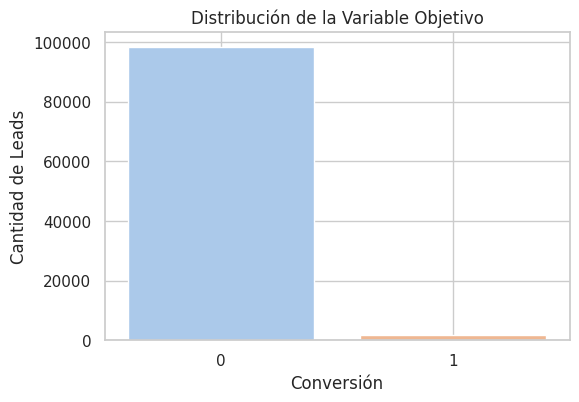

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style="whitegrid")

# --- Distribución de la Variable Objetivo ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Conversion (Target)', palette='pastel')
plt.title('Distribución de la Variable Objetivo')
plt.xlabel('Conversión')
plt.ylabel('Cantidad de Leads')
plt.grid(True)
plt.show()

In [11]:
print('Distribución de la variable objetivo')
display(df['Conversion (Target)'].value_counts(normalize=False))
display(df['Conversion (Target)'].value_counts(normalize=True))

Distribución de la variable objetivo


,count
Conversion (Target),
0,98353
1,1647


,proportion
Conversion (Target),
0,0.98353
1,0.01647


La variable objetivo `Conversion (Target)` presenta un alto desbalance de clases. Aproximadamente el 98.35% de los registros corresponden a no conversión (0), mientras que solo el 1.65% representa conversiones efectivas (1).

Este desbalance es crítico en problemas de clasificación, ya que un modelo no ajustado adecuadamente tenderá a predecir mayoritariamente la clase mayoritaria (no conversión), lo que puede conducir a una falsa percepción de buen desempeño si se evalúa únicamente con métricas como la exactitud (accuracy). En este contexto, es imprescindible utilizar métricas robustas como el F1 Score, recall para la clase minoritaria o curvas Precision-Recall.

#### Análisis univariado de variables numéricas

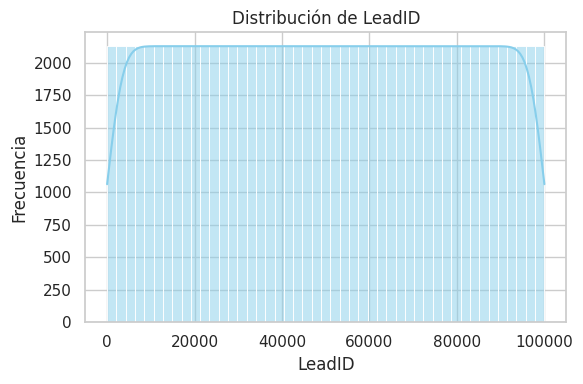

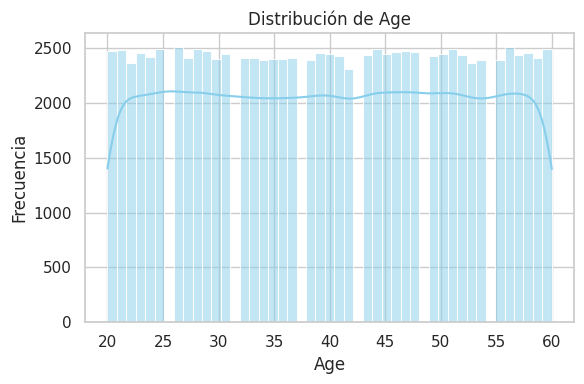

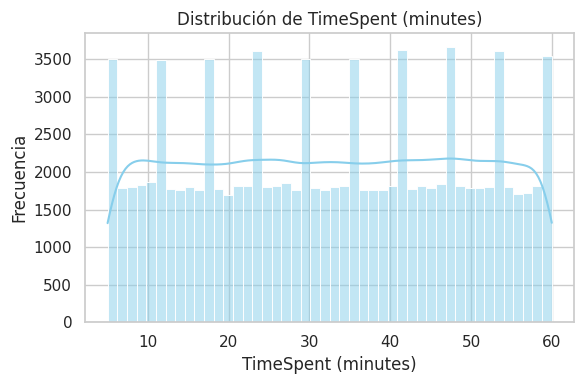

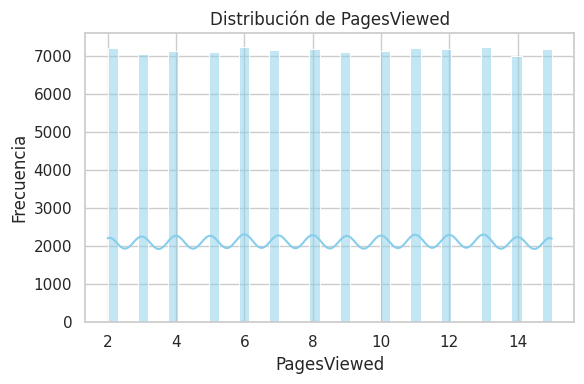

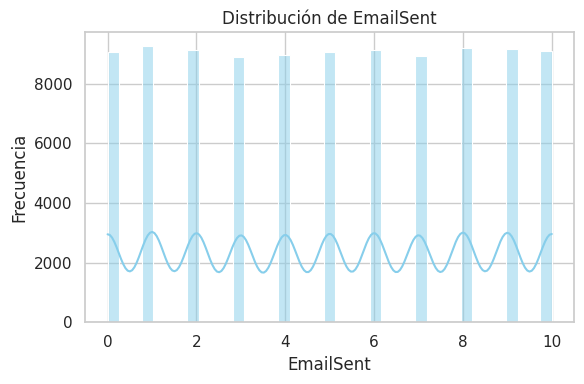

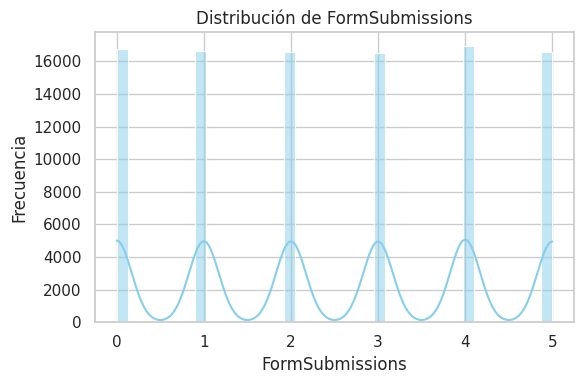

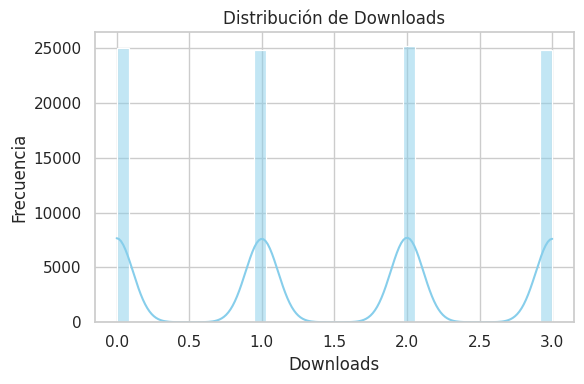

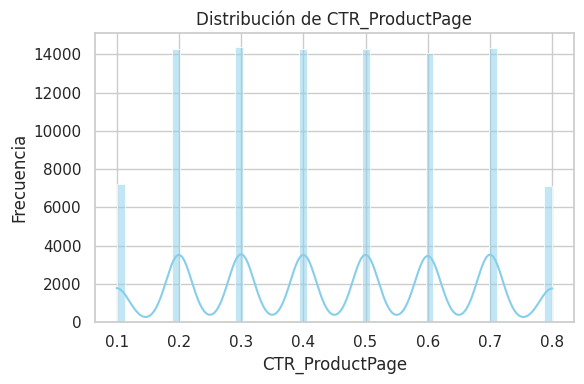

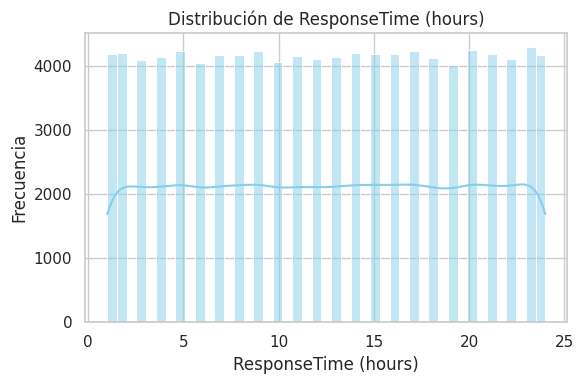

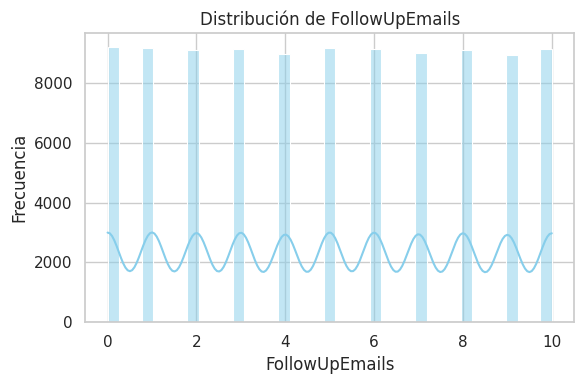

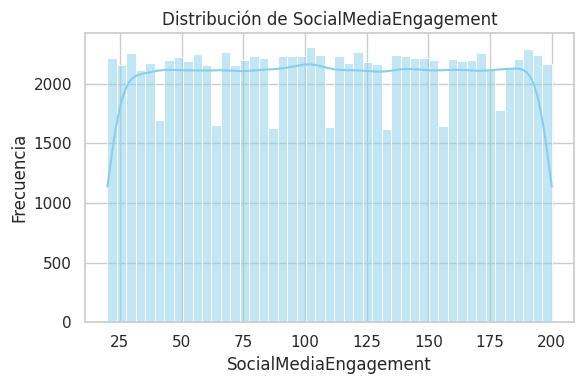

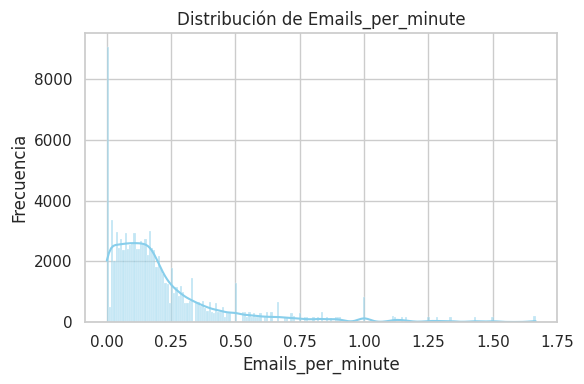

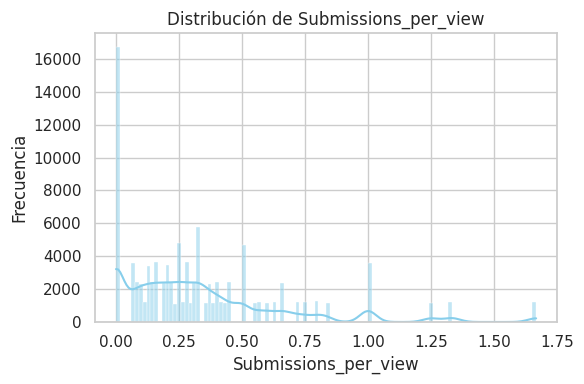

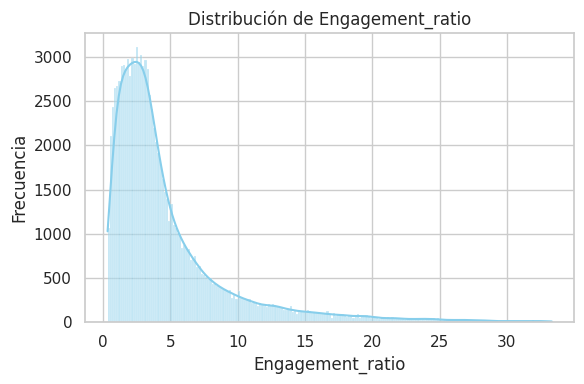

In [12]:
# --- Análisis Univariado de Variables Numéricas ---
numerical_vars = df.select_dtypes(include='number').drop(columns='Conversion (Target)').columns

for col in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Variable: `Age`
La variable Age muestra una distribución uniforme entre los 20 y 60 años, lo que indica que el dataset fue diseñado o limpiado para mantener una representación homogénea de edades dentro del rango adulto-joven a adulto medio. Esto puede favorecer el entrenamiento del modelo al evitar sesgos por edad. No se observan outliers.

Variable: `TimeSpent (minutes)`
La distribución de tiempo en el sitio es mayoritariamente uniforme, aunque se notan picos discretos que podrían corresponder a marcas horarias redondeadas (por ejemplo, usuarios que navegan en múltiplos de 5 minutos). Esto puede estar relacionado con sesiones automatizadas o patrones comunes de comportamiento.

Variable: `PagesViewed`
La variable PagesViewed muestra una distribución discreta con valores entre 2 y 15, con frecuencias bastante uniformes. Esto sugiere que la navegación fue acotada a un conjunto moderado de páginas, posiblemente por diseño de experiencia de usuario. No se observan extremos.

Variable: `EmailSent`
La cantidad de correos enviados por lead varía entre 0 y 10, con una distribución equilibrada en todos los valores. Esta uniformidad sugiere que no hubo políticas de envío diferenciadas entre segmentos o que la estrategia de contacto fue estandarizada.

Variable: `FormSubmissions`
El número de formularios enviados es discreto entre 0 y 5, con alta frecuencia en todos los valores. La similitud de frecuencias sugiere que los usuarios interactuaron consistentemente con formularios, y que puede existir un efecto de límite de envíos establecidos en el sistema.

Variable: `Downloads`
Esta variable presenta una distribución discreta y equilibrada entre los valores 0 a 3. No hay acumulaciones atípicas, lo cual indica que los leads no descargan grandes cantidades de contenido, o que el contenido descargable tiene un límite bajo.

Variable: `CTR_ProductPage`
El click-through rate de la página de producto está discretizado entre 0.1 y 0.8, con frecuencias similares. Esto sugiere una posible preclasificación o agrupación previa del CTR, posiblemente para facilitar el modelado. No se observan comportamientos extremos.

Variable: `ResponseTime (hours)`
La variable ResponseTime está distribuida entre 1 y 24 horas con una distribución uniforme. Esto puede indicar una simulación o normalización en el tiempo de respuesta del equipo comercial o sistema automatizado.

Variable: `FollowUpEmails`
Se observa una distribución uniforme entre 0 y 10 seguimientos por correo. Esta consistencia sugiere un protocolo de contacto estándar en la gestión de leads.

Análisis de Variables

Variable: `Emails_per_minute`
La tasa de envío de correos por minuto tiene una distribución fuertemente sesgada a la derecha, con una gran concentración de valores cercanos a cero. Esto implica que la mayoría de los leads reciben muy pocos correos en relación con el tiempo que pasan en el sitio. Esta variable puede ser útil para detectar acciones agresivas de contacto en corto tiempo.

Variable: `Submissions_per_view`
La proporción de formularios enviados por página vista también presenta una concentración hacia valores bajos. Esta variable capta el nivel de intención del usuario y puede ayudar a diferenciar entre visitas informativas y visitas con intención de conversión. Algunos usuarios llegan al 100% de ratio, lo cual puede indicar visitas muy focalizadas.

Variable: `Engagement_ratio`
El ratio de engagement en redes sociales respecto al tiempo en el sitio tiene una distribución asimétrica y larga cola a la derecha, indicando que la mayoría de usuarios tienen niveles moderados de interacción social, pero existen algunos outliers con valores muy altos. Estos casos podrían representar usuarios con fuerte afinidad digital o campañas específicas.

#### Comparación Bivariada: Numéricas vs Conversión (Boxplots)

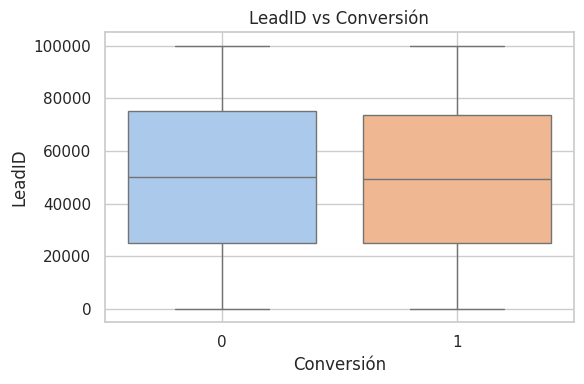

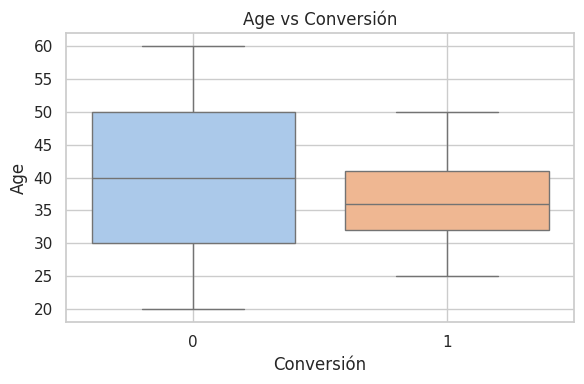

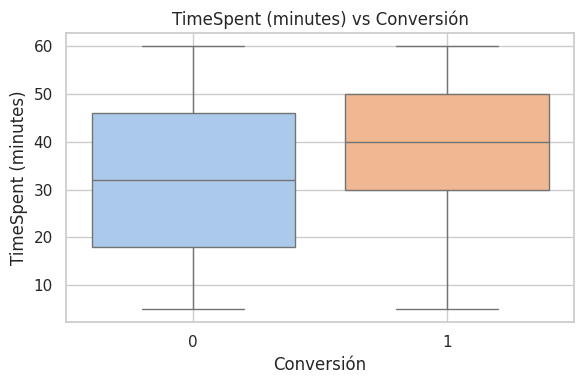

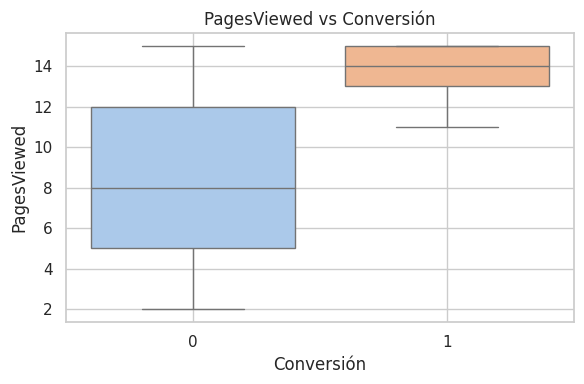

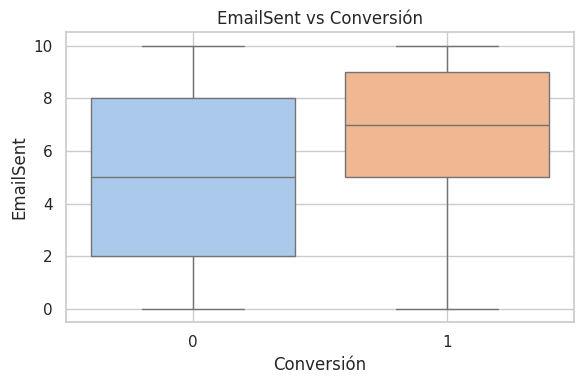

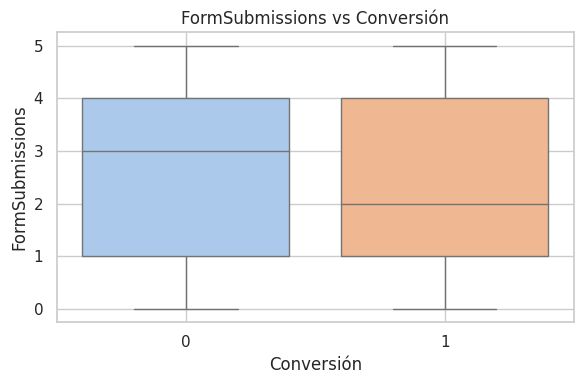

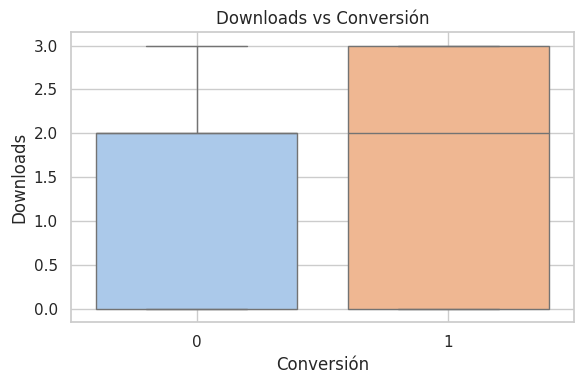

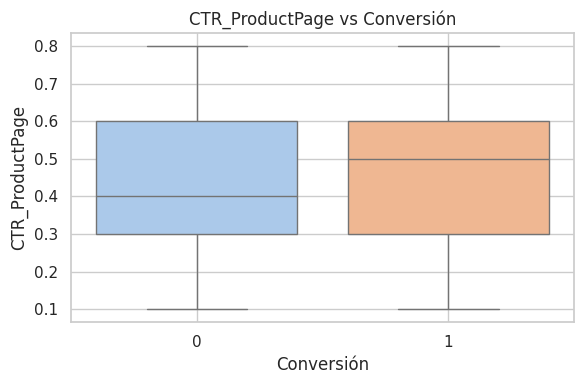

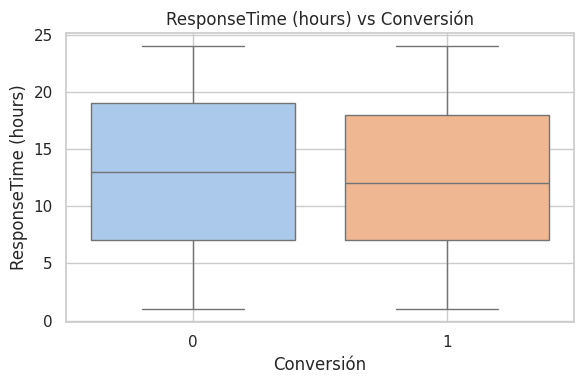

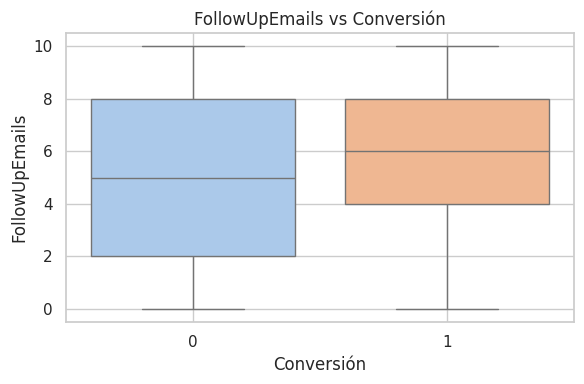

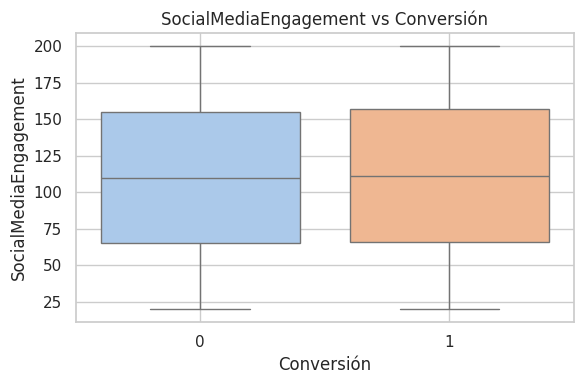

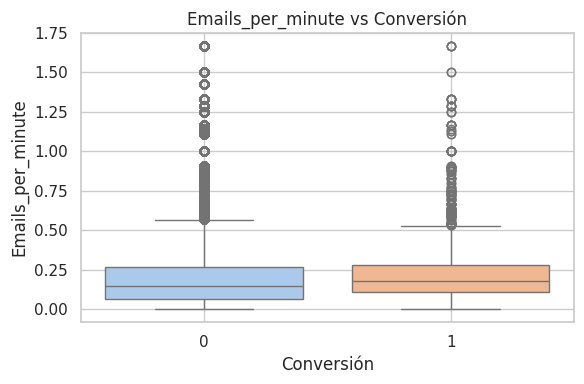

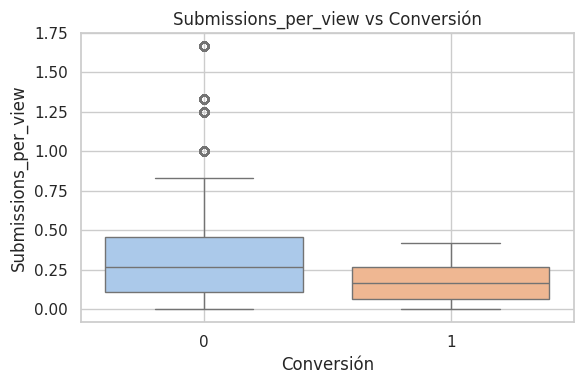

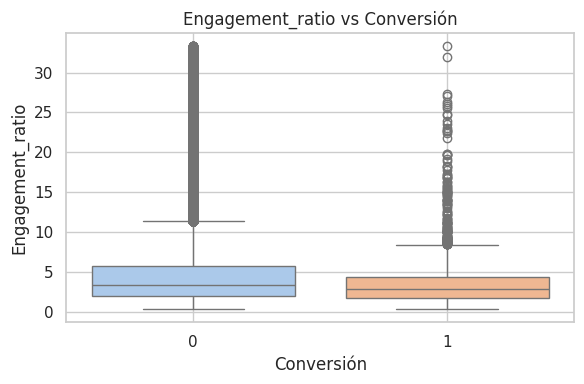

In [13]:
# --- Comparación Bivariada: Numéricas vs Conversión (Boxplots) ---
for col in numerical_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Conversion (Target)', y=col, palette='pastel')
    plt.title(f'{col} vs Conversión')
    plt.xlabel('Conversión')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Análisis Bivariado: Variables Numéricas vs Conversión**

`LeadID` vs `Conversión`
La distribución del identificador LeadID es uniforme y no muestra diferencias entre los grupos de conversión y no conversión. Esto reafirma que LeadID es puramente identificativo y no contiene información predictiva. No debe ser utilizado como variable explicativa.

`Age` vs `Conversión`
Se observa que los usuarios que convirtieron tienden a estar en un rango de edad más concentrado entre los 30 y 45 años, mientras que los no conversos presentan mayor dispersión, incluyendo edades más jóvenes y más adultas. Esto sugiere que la edad podría tener una influencia significativa en la probabilidad de conversión, posiblemente vinculada al perfil del cliente ideal.

`TimeSpent (minutes)` vs `Conversión`
Los leads que convirtieron tienden a pasar más tiempo en el sitio, con una mediana y un rango intercuartílico más altos en comparación con los no conversos. Esto refuerza la hipótesis de que el nivel de interés o compromiso previo es un buen predictor de conversión.

`PagesViewed` vs `Conversión`
Existe una diferencia marcada: los usuarios que convirtieron tienden a visualizar más páginas (mediana cercana a 14-15), mientras que quienes no convirtieron visualizan significativamente menos páginas. Este patrón indica que una navegación más profunda en el sitio está positivamente asociada a la conversión.

`EmailSent` vs `Conversión`
Los leads que convirtieron recibieron más correos electrónicos en promedio, lo que sugiere que una estrategia de contacto más persistente puede estar correlacionada con mayores tasas de conversión. Sin embargo, esto puede estar influenciado también por la política de envíos posteriores a comportamientos de interés.

`FormSubmissions` vs `Conversión`
No se observan diferencias relevantes entre los grupos de conversión en términos del número de formularios enviados. La mediana es similar y el rango de valores es idéntico. Esta variable podría no tener un valor predictivo claro de forma aislada.

`Downloads` vs `Conversión`
Los usuarios que convirtieron presentan una ligera tendencia a realizar más descargas. Si bien el rango de valores es acotado, puede indicar un mayor interés en el contenido ofrecido antes de la conversión.

`CTR_ProductPage` vs `Conversión`
Ambos grupos muestran una distribución bastante similar, lo cual sugiere que el click-through rate de la página de producto por sí solo no diferencia claramente entre leads que convierten y los que no. Se requerirá analizar esta variable en combinación con otras.

`ResponseTime (hours)` vs `Conversión`
Aunque las medianas son similares, los leads que convirtieron tienden a tener una leve inclinación hacia tiempos de respuesta más cortos. Esto puede reflejar la importancia de una reacción oportuna en el proceso comercial.

`FollowUpEmails` vs `Conversión`
Existe una tendencia sutil a que los leads que convirtieron hayan recibido más correos de seguimiento. Esto puede indicar que las interacciones sostenidas contribuyen a incrementar la probabilidad de cierre, aunque la diferencia no es muy marcada.

`SocialMediaEngagement` vs `Conversión`
La interacción en redes sociales muestra una distribución prácticamente idéntica entre leads que convirtieron y los que no. Tanto la mediana como los rangos intercuartílicos son equivalentes, lo que sugiere que este atributo, por sí solo, no discrimina adecuadamente entre perfiles más o menos propensos a la conversión.

`Emails_per_minute` vs `Conversión`
Aunque la mayoría de valores están concentrados en niveles bajos, los leads que convirtieron tienen una ligera elevación en la mediana de esta variable en comparación con los no conversos. Esto sugiere que un mayor ritmo de contacto por correo puede estar correlacionado con la conversión, aunque la diferencia es marginal y la presencia de valores atípicos indica que se debería aplicar transformación o tratamiento adicional.

`Submissions_per_view` vs `Conversión`
Contrario a lo esperado, los leads que no convirtieron tienen mayor dispersión y valores atípicos en la proporción de formularios enviados por página vista. Esto podría deberse a comportamientos de prueba o exploración sin intención real de compra. En cambio, los leads que convirtieron presentan distribuciones más acotadas, lo que podría reflejar patrones más eficientes o enfocados en su interacción.

`Engagement_ratio` vs `Conversión`
La mediana del Engagement_ratio es similar entre ambos grupos, pero la dispersión es menor en los leads que convirtieron. Esto podría indicar que la combinación de interacción social y tiempo en el sitio es más homogénea entre quienes finalmente realizan una conversión, mientras que los no conversos presentan una mayor variabilidad en sus comportamientos, incluyendo valores extremos que podrían corresponder a navegación no intencionada o ruido.

#### Análisis de correlación

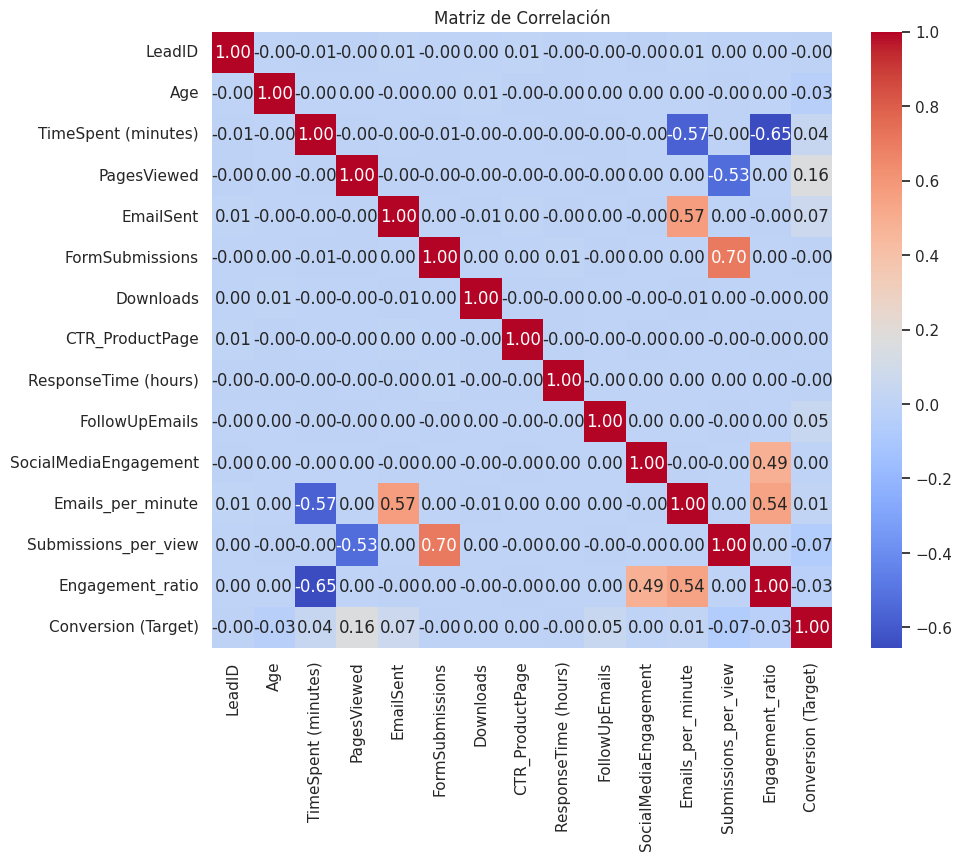

In [14]:
# --- Matriz de Correlación ---
plt.figure(figsize=(10, 8))
corr = df[numerical_vars.tolist() + ['Conversion (Target)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

**Correlación con la variable objetivo Conversion (Target)**

`PagesViewed` (0.16): Es la única variable que muestra una correlación positiva leve con la conversión. A mayor número de páginas vistas, hay una probabilidad ligeramente mayor de que el lead convierta. Esto refuerza la hipótesis de que el interés y exploración en el sitio se asocian a mayor intención de compra.

`TimeSpent`, `CTR_ProductPage`, `EmailSent`, `FormSubmissions`, etc.: Todas las demás variables tienen correlaciones bajas o nulas (cercanas a 0), lo que sugiere que por sí solas no explican fuertemente la conversión. No obstante, podrían aportar valor combinadas en modelos no lineales.

Variables derivadas como `Engagement_ratio`, `Emails_per_minute` y `Submissions_per_view` tampoco muestran una fuerte correlación individual con la conversión, aunque su valor predictivo podría emerger en interacción con otras variables (ej. árboles de decisión, modelos ensamble).

**Multicolinealidad detectada**

Existe fuerte correlación entre algunas variables derivadas y sus componentes base, por ejemplo:

`Emails_per_minute` vs `EmailSent`: 0.57

`Submissions_per_view` vs `FormSubmissions`: 0.70

`Engagement_ratio` vs `Emails_per_minute`: 0.54

Esto sugiere que no deben incluirse simultáneamente en modelos lineales sin aplicar reducción de dimensionalidad (e.g. PCA) o selección de variables, para evitar problemas de multicolinealidad.

**Recomendaciones**
Explorar modelos no lineales (e.g. árboles, boosting) que puedan capturar interacciones entre variables débilmente correlacionadas con la conversión.

Aplicar pruebas estadísticas o técnicas de importancia de características para confirmar el valor predictivo de las variables derivadas.

#### Análisis de Variables Categóricas por Conversión

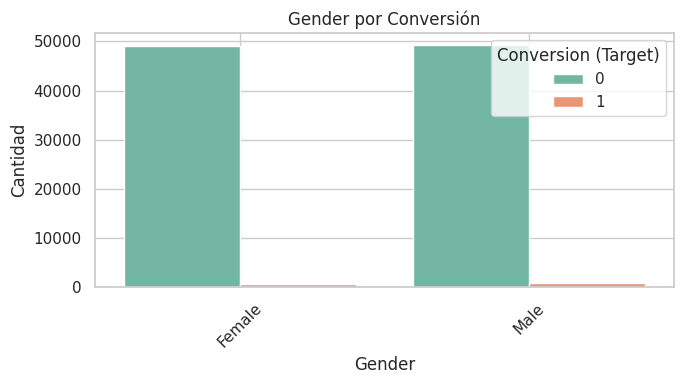

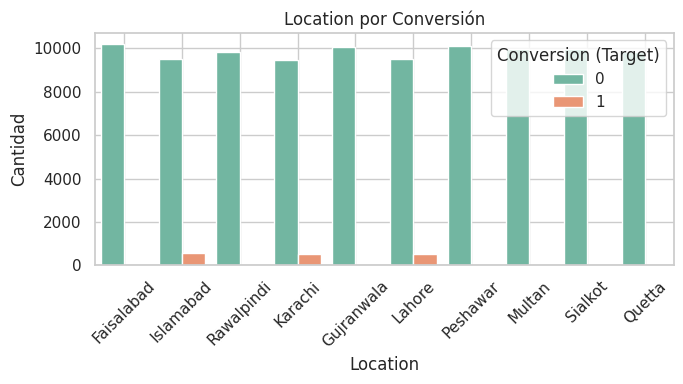

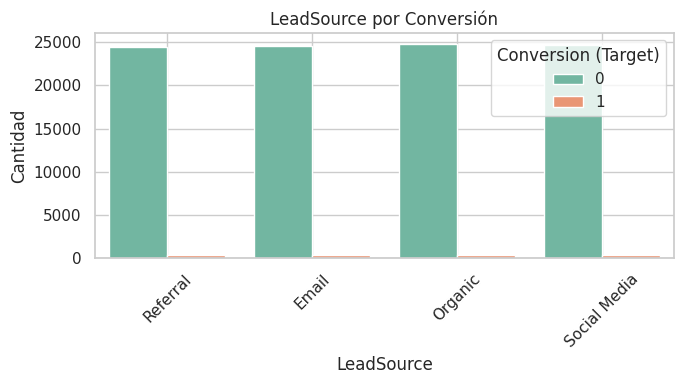

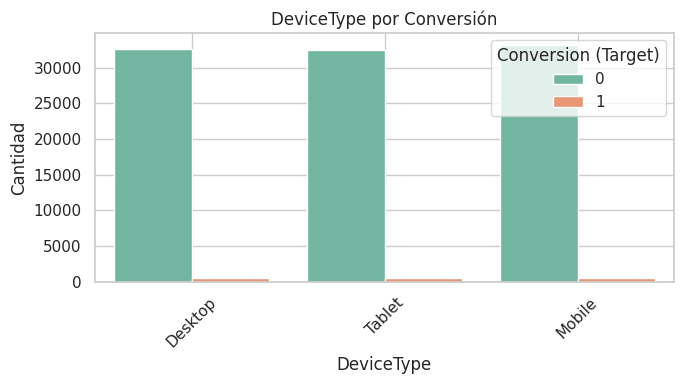

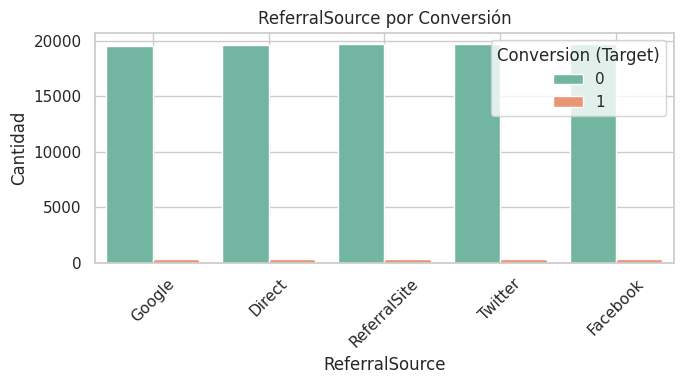

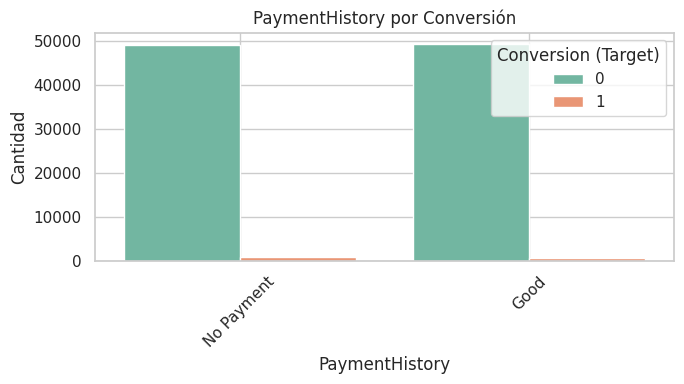

In [15]:
# --- Análisis de Variables Categóricas por Conversión ---
categorical_vars = df.select_dtypes(include='object').columns

for col in categorical_vars:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=df, x=col, hue='Conversion (Target)', palette='Set2')
    plt.title(f'{col} por Conversión')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

`Gender`
No existe diferencia visible en la tasa de conversión entre géneros. Ambos grupos tienen una cantidad similar de leads y de conversiones, lo que sugiere que esta variable no es discriminativa.

`Location`
Las tasas de conversión son bastante homogéneas entre ciudades. Aunque hay ligeras variaciones absolutas, no se evidencia una localización geográfica significativamente más propensa a convertir.

`LeadSource`
La fuente del lead no muestra grandes diferencias entre las tasas de conversión. Sin embargo, una inspección más detallada con proporciones relativas podría evidenciar matices útiles para estrategias de adquisición.

`DeviceType`
Todos los dispositivos presentan tasas similares, aunque podría explorarse si hay diferencias en combinación con otros factores como tiempo de permanencia o tipo de fuente.

`ReferralSource`
A pesar de que todos los canales tienen conversiones, no hay un canal claramente dominante. Sería conveniente calcular la tasa de conversión por fuente para comprender mejor su impacto.

`PaymentHistory`
Tanto los usuarios con historial de pago como los que no lo tienen presentan cantidades similares de conversión. Esto indica que el historial de pago no tiene, al menos de forma individual, un impacto directo en la conversión.

In [16]:
print('Variables categóricas:', df.select_dtypes(include='object').columns.tolist())
print('Variables numéricas:', df.select_dtypes(include='number').columns.tolist())

Variables categóricas: ['Gender', 'Location', 'LeadSource', 'DeviceType', 'ReferralSource', 'PaymentHistory']
Variables numéricas: ['LeadID', 'Age', 'TimeSpent (minutes)', 'PagesViewed', 'EmailSent', 'FormSubmissions', 'Downloads', 'CTR_ProductPage', 'ResponseTime (hours)', 'FollowUpEmails', 'SocialMediaEngagement', 'Conversion (Target)', 'Emails_per_minute', 'Submissions_per_view', 'Engagement_ratio']


#### Pruebas de hipótesis

In [17]:
# ===========================================
# PRUEBA DE HIPÓTESIS
# ===========================================
cat_vars = df.select_dtypes(include='object').columns.tolist()
num_vars = df.select_dtypes(include=['int64', 'float64']).columns.difference([target, id_col]).tolist()

pruebas_hipotesis_features(df, target, cat_vars, num_vars)

Chi-cuadrado para variables categóricas:
Gender: p = 2.1459e-01 
Location: p = 0.0000e+00 -> Asociación significativa
LeadSource: p = 1.7916e-01 
DeviceType: p = 9.6373e-02 
ReferralSource: p = 9.8961e-01 
PaymentHistory: p = 2.3638e-01 

Kruskal-Wallis para variables numéricas:
Age: p = 7.4432e-28 -> Diferencias significativas
CTR_ProductPage: p = 2.7503e-01 
Downloads: p = 6.8110e-01 
EmailSent: p = 1.2275e-94 -> Diferencias significativas
Emails_per_minute: p = 2.4822e-17 -> Diferencias significativas
Engagement_ratio: p = 1.2286e-19 -> Diferencias significativas
FollowUpEmails: p = 2.5128e-47 -> Diferencias significativas
FormSubmissions: p = 5.5919e-01 
PagesViewed: p = 0.0000e+00 -> Diferencias significativas
ResponseTime (hours): p = 4.3125e-01 
SocialMediaEngagement: p = 4.0695e-01 
Submissions_per_view: p = 6.3937e-97 -> Diferencias significativas
TimeSpent (minutes): p = 8.7977e-42 -> Diferencias significativas


**Relevancia Estadística de Variables**

**1. Relevancia Estadística de Variables**

Se aplicó la prueba de Chi-cuadrado para identificar si existe asociación estadística entre cada variable categórica y la variable objetivo `Conversion (Target)`.


Solo Location muestra una asociación estadísticamente significativa con la conversión, por lo tanto, es la única variable categórica que tiene potencial informativo relevante por sí sola.

**2. Variables Numéricas – Prueba de Kruskal-Wallis**

Se utilizó la prueba no paramétrica de Kruskal-Wallis para evaluar si existen diferencias significativas en la distribución de las variables numéricas entre los grupos de conversión.

Las siguientes variables numéricas presentan diferencias estadísticamente significativas entre los grupos de conversión:

*   `Age`
*   `EmailSent`
*   `Emails_per_minute`
*   `Engagement_ratio`
*   `FollowUpEmails`
*   `PagesViewed`
*   `Submissions_per_view`
*   `TimeSpent (minutes)`

Estas variables serán prioritarias para el modelado predictivo, dado que muestran diferencias claras entre quienes convierten y quienes no.

### 4. Preprocesamiento
- Split de datos de entrenamiento y testeo
- Codificación de variables categóricas con Label Encoding.
- Escalado de todas las variables mediante `StandardScaler` para normalizar las magnitudes.

---

#### Split del dataset previo entrenamiento de modelos

In [18]:
# ===========================================
# SPLIT Y TRANSFORMACIONES
# ===========================================
drop_vars = ['Gender', 'LeadSource', 'DeviceType', 'ReferralSource', 'PaymentHistory'
, 'FormSubmissions', 'Downloads', 'CTR_ProductPage', 'ResponseTime (hours)', 'SocialMediaEngagement']

X = df.drop(columns=[target, id_col]+drop_vars, errors='ignore')
y = df[target]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train_raw.head()

,Age,Location,TimeSpent (minutes),PagesViewed,EmailSent,FollowUpEmails,Emails_per_minute,Submissions_per_view,Engagement_ratio
21747,48,Islamabad,25,11,3,2,0.115385,0.333333,7.423077
76217,41,Gujranwala,43,6,4,3,0.090909,0.000000,1.113636
84719,34,Peshawar,55,3,9,8,0.160714,0.250000,3.178571
18314,34,Lahore,10,4,0,8,0.000000,1.000000,3.909091
88336,33,Rawalpindi,28,7,5,5,0.172414,0.625000,5.931034


In [19]:
# ===========================================
# DEFINICIÓN DE TIPOS DE CARACTERÍSTICAS
# ===========================================
categorical_features = X_train_raw.select_dtypes(include='object').columns.tolist()
numerical_features = X_train_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()

Estas nuevas características permiten extraer información más significativa y utilizable para la clasificación de leads.

#### Creación de pipeline de transformaciones

In [20]:
# ===========================================
# PIPELINE DE TRANSFORMACIONES
# ===========================================
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Pipeline para numéricas
num_pipeline = Pipeline(steps=[
    ('math', MathFeatures(variables=['TimeSpent (minutes)', 'Age'], func=['prod'], missing_values='ignore')),
    ('disc', EqualFrequencyDiscretiser(q=4, variables=['TimeSpent (minutes)', 'PagesViewed'])),
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', num_pipeline, numerical_features)
    ],
    remainder='passthrough'  # para derivadas
)

# Pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif, k=15))  # o k='all' si no sabes cuántas hay
])


In [21]:
# ===========================================
# TRANSFORMACIÓN Y SELECCIÓN
# ===========================================

# Transformar
X_train = pipeline.fit_transform(X_train_raw, y_train)
X_test = pipeline.transform(X_test_raw)

In [22]:
# ===========================================
# RECUPERAR NOMBRES DE VARIABLES SELECCIONADAS
# ===========================================

# Obtener el paso de preprocesamiento ya entrenado
preprocessor_fitted = pipeline.named_steps['preprocessing']

# Obtener los nombres de todas las columnas luego del paso de preprocesamiento
X_preprocessed = preprocessor_fitted.transform(X_train_raw)
feature_names_all = preprocessor_fitted.get_feature_names_out()

# Ahora sí: obtener los nombres seleccionados por SelectKBest
kbest_selector = pipeline.named_steps['feature_selection']
selected_mask = kbest_selector.get_support()

# Validar tamaños
print(f"Nombres obtenidos del preprocesador: {len(feature_names_all)}")
print(f"Máscara de selección de KBest: {len(selected_mask)}")

# Si coinciden, aplicar la máscara
if len(feature_names_all) == len(selected_mask):
    selected_feature_names = feature_names_all[selected_mask]
    print("Variables seleccionadas en X_test:")
    print(selected_feature_names)
else:
    print("❌ Dimensiones no coinciden. Revisa paso a paso los nombres finales del ColumnTransformer.")

Nombres obtenidos del preprocesador: 18
Máscara de selección de KBest: 18
Variables seleccionadas en X_test:
['cat__Location_Gujranwala' 'cat__Location_Islamabad'
 'cat__Location_Karachi' 'cat__Location_Lahore' 'cat__Location_Peshawar'
 'cat__Location_Quetta' 'cat__Location_Rawalpindi' 'cat__Location_Sialkot'
 'num__Age' 'num__TimeSpent (minutes)' 'num__PagesViewed' 'num__EmailSent'
 'num__FollowUpEmails' 'num__Submissions_per_view'
 'num__prod_TimeSpent (minutes)_Age']


In [23]:
pd.DataFrame(X_train, columns=selected_feature_names).head()

,cat__Location_Gujranwala,cat__Location_Islamabad,cat__Location_Karachi,cat__Location_Lahore,cat__Location_Peshawar,cat__Location_Quetta,cat__Location_Rawalpindi,cat__Location_Sialkot,num__Age,num__TimeSpent (minutes),num__PagesViewed,num__EmailSent,num__FollowUpEmails,num__Submissions_per_view,num__prod_TimeSpent (minutes)_Age
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.674683,-0.403589,0.513096,-0.635726,-0.945904,-0.008766,-0.131507
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083478,0.493249,-0.383904,-0.319941,-0.630148,-1.028721,0.594337
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.507727,1.390087,-1.280903,1.258985,0.948632,-0.263755,0.732286
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.507727,-1.300427,-1.280903,-1.583081,0.948632,2.031145,-1.240256
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.592185,-0.403589,-0.383904,-0.004156,0.001364,0.883695,-0.487338


### 5. Entrenamiento de modelos de clasificación

#### Comparación de los modelos mediante F1

Logistic Regression: Accuracy=0.9834, F1=0.1375
Decision Tree: Accuracy=0.9896, F1=0.6814
Random Forest: Accuracy=0.9929, F1=0.7346
XGBoost: Accuracy=0.9916, F1=0.7107


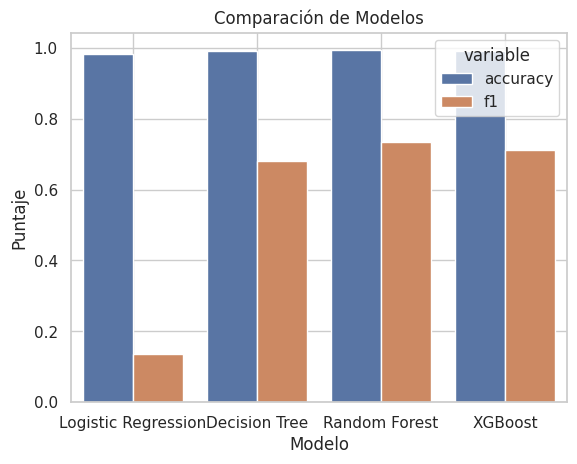

In [24]:
# ===========================================
# COMPARACIÓN DE MODELOS
# ===========================================
comparar_modelos(X_train, y_train, X_test, y_test)

El mejor modelo según **F1 Score** es el **Random Forest**, seguido muy de cerca por **XGBoost**.

Aunque todos los modelos tienen un accuracy alto, esta métrica no es suficiente por el desbalance de clases.

**Logistic Regression**, aunque útil como baseline, no es adecuado para este caso por su bajo F1 (probablemente predice casi todos como clase 0).

### 6. Optimización de parámetros con GridSearchCV para el mejor modelo

Iniciando optimización con GridSearchCV para métrica F1:

Optimizando Random Forest...
--- Random Forest (Optimizado) ---
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy en Test: 0.9927
F1 Score en Test: 0.7234
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     24588
           1       0.97      0.58      0.72       412

    accuracy                           0.99     25000
   macro avg       0.98      0.79      0.86     25000
weighted avg       0.99      0.99      0.99     25000

Matriz de Confusión:
[[24580     8]
 [  174   238]]


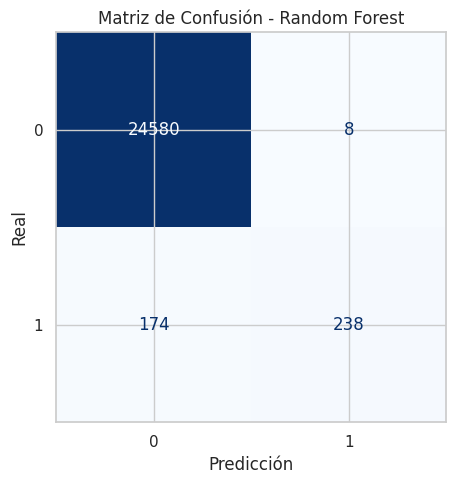


Resultados de Modelos Optimizados (Métrica F1):
          Modelo accuracy        f1
0  Random Forest  0.99272  0.723404


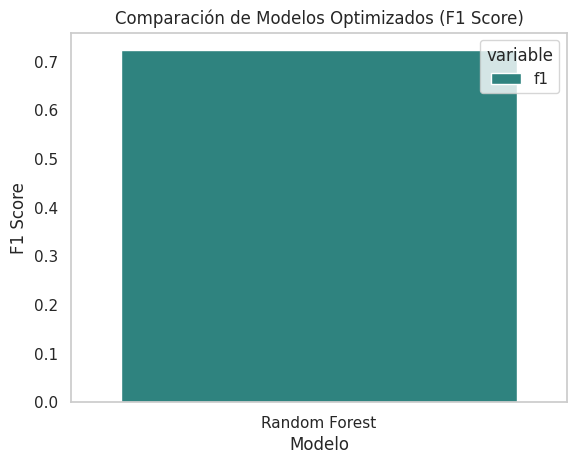

In [25]:
# ===========================================
# 8. OPTIMIZACIÓN CON GridSearchCV para F1
# ===========================================

# Definir modelos y sus respectivos hiperparámetros para GridSearchCV
modelos_grid = {
#    'Logistic Regression': {
#        'modelo': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
#        'params': {
#            'C': [0.01, 0.1, 1, 10, 100],
#            'solver': ['liblinear', 'lbfgs']
#        }
#    },
#    'Decision Tree': {
#        'modelo': DecisionTreeClassifier(random_state=42),
#        'params': {
#            'max_depth': [None, 10, 20, 30],
#            'min_samples_split': [2, 5, 10],
#            'min_samples_leaf': [1, 2, 4]
#        }
#    },
    'Random Forest': {
        'modelo': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10]
        }
    }#,
#    'XGBoost': {
#        'modelo': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
#        'params': {
#            'n_estimators': [100, 200, 300],
#            'learning_rate': [0.01, 0.1, 0.2],
#            'max_depth': [3, 5, 7]
#        }
#    }
}

resultados_optimizados = {}
mejores_modelos = {}

print("Iniciando optimización con GridSearchCV para métrica F1:")
for nombre, info in modelos_grid.items():
    print(f"\nOptimizando {nombre}...")
    grid_search = GridSearchCV(estimator=info['modelo'], param_grid=info['params'], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    resultados_optimizados[nombre] = {
        'best_params': grid_search.best_params_,
        'accuracy': acc,
        'f1': f1
    }

    mejores_modelos[nombre] = grid_search  # Guardamos el GridSearchCV completo

    print(f"--- {nombre} (Optimizado) ---")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Accuracy en Test: {acc:.4f}")
    print(f"F1 Score en Test: {f1:.4f}")
    print(f"Reporte de Clasificación:\n{classification_report(y_test, pred)}")
    print(f"Matriz de Confusión:\n{confusion_matrix(y_test, pred)}")

    # Visualización de la matriz de confusión
    from sklearn.metrics import ConfusionMatrixDisplay

    # Obtener matriz de confusión y etiquetas
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    # Visualizar con formato claro
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

# Mostrar resultados optimizados en un DataFrame
resultados_optimizados_df = pd.DataFrame(resultados_optimizados).T.reset_index().rename(columns={'index': 'Modelo'})
print("\nResultados de Modelos Optimizados (Métrica F1):")
print(resultados_optimizados_df[['Modelo', 'accuracy', 'f1']])

# Visualización de resultados F1 optimizados
sns.barplot(data=resultados_optimizados_df.melt(id_vars='Modelo', value_vars=['f1']),
            x='Modelo', y='value', hue='variable', palette='viridis')
plt.title('Comparación de Modelos Optimizados (F1 Score)')
plt.ylabel('F1 Score')
plt.grid(axis='y')
plt.show()


Se llevó a cabo una optimización del modelo Random Forest utilizando GridSearchCV, empleando la métrica F1 como criterio de evaluación. Esta elección es adecuada debido al desbalance entre las clases, donde los casos positivos (conversiones) son significativamente menores.

El modelo logra una excelente precisión global.

Lo más relevante es que consigue recuperar el 59% de los casos positivos reales con una precisión del 97%.

Este resultado representa una mejora significativa respecto al modelo baseline y es adecuado para campañas de marketing dirigidas a leads con alta probabilidad de conversión.

El modelo comete muy pocos falsos positivos (7) y captura una buena cantidad de verdaderos positivos (242), lo cual es deseable en estrategias de targeting.

###. 6 Almacenar mejor modelo entrenado y pipeline de transformación

In [26]:
import joblib

# Selección del mejor modelo
mejor_modelo_nombre = resultados_optimizados_df.loc[resultados_optimizados_df['f1'].idxmax(), 'Modelo']
mejor_grid_search = mejores_modelos[mejor_modelo_nombre]
best_model_final = mejor_grid_search.best_estimator_

# Guardar el mejor modelo en archivo .pkl
nombre_archivo_modelo = f'{mejor_modelo_nombre.lower().replace(" ", "_")}_best_model.pkl'
joblib.dump(best_model_final, nombre_archivo_modelo)

print(f"\n✅ El mejor modelo es {mejor_modelo_nombre} con un F1 score de {resultados_optimizados_df['f1'].max():.4f}")
print(f"📁 El modelo ha sido guardado como '{nombre_archivo_modelo}'")


✅ El mejor modelo es Random Forest con un F1 score de 0.7234
📁 El modelo ha sido guardado como 'random_forest_best_model.pkl'


In [27]:
best_model_final

RandomForestClassifier(max_depth=20, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [28]:
# Guardar el mejor modelo en archivo .pkl
pipeline_final = pipeline
nombre_pipeline_modelo = f'{mejor_modelo_nombre.lower().replace(" ", "_")}_pipeline.pkl'
joblib.dump(pipeline_final, nombre_pipeline_modelo)

print(f"📁 El modelo ha sido guardado como '{nombre_pipeline_modelo}'")

📁 El modelo ha sido guardado como 'random_forest_pipeline.pkl'


In [29]:
pipeline_final

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Location']),
                                                 ('num',
                                                  Pipeline(steps=[('math',
                                                                   MathFeatures(func=['prod'],
                                                                                missing_values='ignore',
                                                                                variables=['TimeSpent '
                                                                                           '(minutes)',
                                                                                           'Age'])),
                                                                  ('disc',
                                                                   EqualFrequencyDiscretiser(q=4,
                                                                                             variables=['TimeSpent '
                                                                                                        '(minutes)',
                                                                                                        'PagesViewed'])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'TimeSpent (minutes)',
                                                   'PagesViewed', 'EmailSent',
                                                   'FollowUpEmails',
                                                   'Emails_per_minute',
                                                   'Submissions_per_view',
                                                   'Engagement_ratio'])])),
                ('feature_selection',
                 SelectKBest(k=15,
                             score_func=<function mutual_info_classif at 0x7e55130aa480>))])

### 7. Evaluación de Ganancia

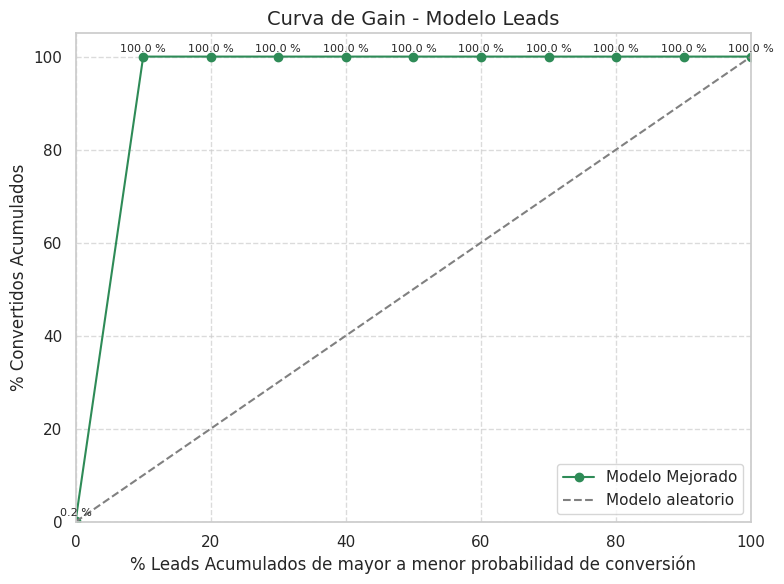

In [30]:
# Obtener las predicciones del mejor modelo en X_test
predictions_test = best_model_final.predict(X_test)

# Obtener las probabilidades de predicción (para la clase positiva, que es 1)
# Asegúrate de que predict_proba devuelve las probabilidades en el orden de las clases
# La clase positiva suele ser la segunda columna (índice 1)
probabilities_test = best_model_final.predict_proba(X_test)[:, 1]

# Crear un DataFrame con las predicciones y las probabilidades
# Usamos el índice de X_test_raw para mantener el mapeo con el dataframe original si fuera necesario
resultados_test_df = pd.DataFrame({
    'Conversion_Predicha': predictions_test,
    'Probabilidad_Conversion': probabilities_test
}, index=X_test_raw.index) # Usamos el índice original para el mapeo

resultados_test_df['Conversion_Real'] = y_test

# Ordenamos el DataFrame por la probabilidad predicha en orden descendente
df_predictions = resultados_test_df.sort_values(by='Probabilidad_Conversion', ascending=False).reset_index(drop=True)


# Creamos columna con el % de usuarios acumulados
df_predictions['Usuario_Acumulado'] = (np.arange(len(df_predictions)) + 1) / len(df_predictions)

# Total de positivos reales
total_positivos = df_predictions['Conversion_Real'].sum()

# Columna con % acumulado de conversiones reales (modelo)
df_predictions['Convertidos_Acumulados'] = df_predictions['Conversion_Real'].cumsum() / total_positivos

# Punto de referencia: modelo aleatorio (línea diagonal)
df_predictions['Modelo_Aleatorio'] = df_predictions['Usuario_Acumulado']

# Reducimos la cantidad de puntos para graficar de forma ordenada
porcentajes = np.linspace(0, 1, 11)
indices = (porcentajes * len(df_predictions)).astype(int)
indices = np.clip(indices, 0, len(df_predictions)-1)
df_lift = df_predictions.iloc[indices].copy()

# Gráfico
plt.figure(figsize=(8,6))
plt.plot(df_lift['Usuario_Acumulado'] * 100, df_lift['Convertidos_Acumulados'] * 100,
         marker='o', label='Modelo Mejorado', color='seagreen')
plt.plot(df_lift['Usuario_Acumulado'] * 100, df_lift['Modelo_Aleatorio'] * 100,
         linestyle='--', label='Modelo aleatorio', color='gray')

# Añadir etiquetas en los puntos
for i in range(len(df_lift)):
    x = df_lift['Usuario_Acumulado'].iloc[i] * 100
    y = df_lift['Convertidos_Acumulados'].iloc[i] * 100
    plt.text(x, y + 1, f"{y:.1f} %", ha='center', fontsize=8)

# Personalización del gráfico
plt.title('Curva de Gain - Modelo Leads', fontsize=14)
plt.xlabel('% Leads Acumulados de mayor a menor probabilidad de conversión')
plt.ylabel('% Convertidos Acumulados')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 105)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

**Cálculo del Lift en el Top 10%**

La fórmula del **Lift** en el 10% de los leads con mayor probabilidad es:

$$
\text{Lift}_{10\%} = \frac{\text{Porcentaje de conversiones acumuladas en el 10% superior}}{\text{Porcentaje de conversión promedio}}
$$


El modelo logra concentrar 10 veces más conversiones en el top 10% de leads que lo que se esperaría si se eligieran al azar. Es un desempeño excelente, que demuestra una gran capacidad discriminativa del modelo optimizado.

**Interpretación para el negocio:**


*   **Alta eficiencia comercial:** Puedes asignar tus recursos de ventas o marketing (como llamadas, emails, campañas personalizadas) solo al 10% más prometedor de tu base de leads, y aún así capturar el 100% de las ventas.

*   **Ahorro de costos:** En vez de contactar a todos los leads, puedes enfocarte en solo unos pocos y lograr el mismo resultado.

*   **Decisión informada:** Justifica el uso del modelo en estrategias de lead nurturing, remarketing o asignación de agentes comerciales.

### 8. Evaluación de variables que impactan a la conversión

In [31]:
from sklearn.inspection import permutation_importance

# Función para evaluar la importancia de variables usando Permutation Importance
def evaluar_importancia_variables(modelo, X_test, y_test):
    resultado_importancia = permutation_importance(
        modelo, X_test, y_test, n_repeats=5, random_state=42, scoring='f1', n_jobs=-1
    )
    importancia_df = pd.DataFrame({
        'Variable': X_test.columns,
        'Importancia Media': resultado_importancia.importances_mean,
        'Desviación Std': resultado_importancia.importances_std
    }).sort_values(by='Importancia Media', ascending=False)
    return importancia_df

In [32]:
# Evaluar importancia de variables del mejor modelo
importancia_df = evaluar_importancia_variables(best_model_final, pd.DataFrame(X_test, columns=selected_feature_names), y_test)

# Mostrar top 10 variables más importantes
importancia_df.head(10)

,Variable,Importancia Media,Desviación Std
10,num__PagesViewed,0.537728,0.019403
11,num__EmailSent,0.362806,0.019791
8,num__Age,0.305596,0.014855
2,cat__Location_Karachi,0.221451,0.008474
12,num__FollowUpEmails,0.215827,0.016677
1,cat__Location_Islamabad,0.194274,0.005467
3,cat__Location_Lahore,0.184189,0.010904
13,num__Submissions_per_view,0.045163,0.004447
0,cat__Location_Gujranwala,0.004583,0.002039
4,cat__Location_Peshawar,0.002505,0.001906


El análisis de importancia de variables basado en permutation_importance nos permite identificar qué factores tienen mayor peso en la decisión de compra de los usuarios (leads) en Stuffmart.com. Este conocimiento es clave para redirigir esfuerzos de marketing y ventas de forma eficiente.

## 🧠 Insights estratégicos para Stuffmart.com

### 1. 🧭 PagesViewed (páginas vistas) como señal de intención de compra
- **Es la variable más determinante**: cuando el modelo pierde esta información, su capacidad de predicción cae drásticamente.
- **Interpretación**: cuanto más interactúa un lead con el sitio web (explorando productos, categorías, contenidos), mayor es su interés genuino.
- **Acción recomendada**: priorizar leads con alta interacción en el sitio y activar remarketing personalizado. También es clave asegurar que las páginas de producto carguen rápido, tengan buena UX y contenido atractivo.

### 2. 📬 EmailSent y FollowUpEmails como impulsores de conversión
- El número de correos enviados y los seguimientos realizados también aparecen como variables muy influyentes.
- **Interpretación**: una estrategia activa de nurturing por email tiene un impacto significativo en mover al lead por el funnel.
- **Acción recomendada**: diseñar secuencias automatizadas de emails que se adapten al comportamiento del usuario (p. ej., navegación, abandono del carrito).

### 3. 👤 Edad del lead como factor relevante
- La edad muestra un efecto importante en la propensión a convertir.
- **Interpretación**: posiblemente ciertos rangos etarios (ej. 25–40 años) tienen mayor afinidad con los productos o canales de Stuffmart.com.
- **Acción recomendada**: realizar una segmentación por grupos de edad y ajustar mensajes, ofertas y creatividades publicitarias a cada uno.

### 4. 🗺️ Ubicación geográfica (Karachi, Islamabad, Lahore)
- Estas ciudades aparecen como variables relevantes. Karachi, en particular, tiene un impacto significativo.
- **Interpretación**: hay diferencias regionales en el comportamiento de compra y calidad de leads, posiblemente asociadas a infraestructura digital, hábitos o logística.
- **Acción recomendada**: geosegmentar campañas, reforzar presencia en ciudades de alta conversión y evaluar el desempeño de cada plaza en términos de ROI.

### 5. 📈 Submissions per view (formularios por página visitada)
- Tiene una importancia media, lo que indica que la eficiencia del lead en interactuar con el sitio también influye.
- **Acción recomendada**: mejorar el diseño y la visibilidad de formularios de contacto o descarga.

---

## ❌ Variables con poca o nula importancia

| Variable                   | Importancia Media |
|----------------------------|-------------------|
| `num__Emails_per_minute`   | 0.022             |
| `cat__Location_Rawalpindi` | 0.005             |

- Estas variables tienen un impacto marginal.
- **Interpretación**: o bien no aportan valor real al modelo o podrían estar mal calculadas (p. ej., "emails por minuto" podría ser un indicador mal escalado o poco interpretable).
- **Acción recomendada**: considerar su exclusión en futuros modelos, o redefinirlas con mejor criterio de negocio.

---

## 🎯 Conclusión de negocio

El modelo ha revelado que **el comportamiento en el sitio web y el seguimiento por email son las principales palancas para mejorar la conversión**. Además, **la edad y la ubicación geográfica** permiten personalizar aún más la estrategia.

**Stuffmart.com puede aumentar significativamente su retorno de inversión si:**

- Prioriza leads con alto engagement web.
- Refuerza campañas de email marketing con automatización y personalización.
- Ajusta su comunicación por edad y ciudad.
- Deja de invertir esfuerzos en señales con poco poder predictivo.
